# Analyzing the Value Premium

## Introduction
In 1992, Eugene Fama and Kenneth French introduced a Three-Factor Model in their famous paper called "The Cross-Section of Expected Stock Returns" that extends William Sharpe's CAPM with a Size Factor (SMB) and a Value Factor (HML):
<br><br>
$$
E(r) = \alpha + \beta_{1} *  (MKT-R_f) + \beta_{2} * SMB + \beta_{3} * HML
$$
<br>
Given the parsimonous structure, the theoretical existence of state variables that investors want to hedge against and the poor performance of the CAPM, it has become, together with Fama/French's (FF) extended 5-Factor Model, the standard model to price the cross-section of equity returns.
<br>
However, since the publication of the paper, both factors failed to deliver any premium out-of-sample and the value premium (HML) in particular currently experiences a 20-year long drawdown, erasing half of its entire 100-year cumulative outperformance. Sceptics claim that both premia are unrelated to risk and that the model is a result of data snooping. Once the existence of a new factor becomes common knowledge and investors adapt and try to exploit it, it should, via arbitrage, ultimately vanish. 
<br>
While asset pricing theory points to factors aside from the sensitivity to the market portfolio and although the four additional Fama/French factors are theoretically sound as they directly relate to the pricing equation, it is unclear whether they can indeed proxy the underlying risk factors. This notebook puts aside the theory and provides a quantitative analysis of the drivers of the value premium and shows that it cannot be concluded that the value premium vanished.

**Data sources:**
* Kenneth French's Academic Portfolios (https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)
  * In particular *Fama/French 5 Factors* and *6 Portfolios Formed on Size and Book-to-Market (2 x 3)*
* Robert Shiller's History of Bond Rates (http://www.econ.yale.edu/~shiller/data.htm)

#### Importing the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import jarque_bera, norm, gaussian_kde
from finance_data import FrenchReader, ShillerReader

In [2]:
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (12,6)

In [3]:
shiller_data = ShillerReader.cape()[["10-Year Interest Rate", "CAPE", "CPI"]]
shiller_data["10-Year Interest Rate"] /= 100
ff3 = FrenchReader("F-F_Research_Data_Factors").read()["Main"] / 100
ff5 = FrenchReader("F-F_Research_Data_5_Factors_2x3").read()["Main"] / 100
mom = FrenchReader("F-F_Momentum_Factor").read()["Main"] / 100
df = pd.concat([ff3, mom, shiller_data], axis=1).dropna()
df["RMW"] = ff5["RMW"]
df["CMA"] = ff5["CMA"]
df = df[["Mkt-RF", "SMB", "HML", "RMW", "CMA", "Mom", "RF", "10-Year Interest Rate", "CAPE", "CPI"]]
df

,Mkt-RF,SMB,HML,RMW,CMA,Mom,RF,10-Year Interest Rate,CAPE,CPI
1927-01-01,-0.0006,-0.0051,0.0473,NaN,NaN,0.0036,0.0025,0.033400,13.185931,17.500
1927-02-01,0.0418,-0.0025,0.0327,NaN,NaN,-0.0214,0.0026,0.033392,13.633966,17.400
1927-03-01,0.0013,-0.0189,-0.0256,NaN,NaN,0.0361,0.0030,0.033383,14.033258,17.300
1927-04-01,0.0046,0.0049,0.0071,NaN,NaN,0.0430,0.0025,0.033375,14.488222,17.300
1927-05-01,0.0544,0.0146,0.0498,NaN,NaN,0.0300,0.0030,0.033367,15.002347,17.400
...,...,...,...,...,...,...,...,...,...,...
2021-09-01,-0.0437,0.0080,0.0509,-0.0194,0.0208,0.0157,0.0000,0.013700,37.620347,274.310
2021-10-01,0.0665,-0.0228,-0.0044,0.0174,-0.0148,0.0321,0.0000,0.015800,37.253025,276.589
2021-11-01,-0.0155,-0.0135,-0.0053,0.0738,0.0160,0.0082,0.0000,0.015600,38.751781,277.948
2021-12-01,0.0310,-0.0157,0.0323,0.0475,0.0437,-0.0267,0.0001,0.014700,38.657216,278.802


In [4]:
bm_sorted_data = FrenchReader("Portfolios_Formed_on_BE-ME").read()
bm_size_sorted_data = FrenchReader("6_Portfolios_2x3").read()

ep_sorted_data = FrenchReader("Portfolios_Formed_on_E-P").read()
ep_size_sorted_data = FrenchReader("6_Portfolios_ME_EP_2x3").read()

cfp_sorted_data = FrenchReader("Portfolios_Formed_on_CF-P").read()
cfp_size_sorted_data = FrenchReader("6_Portfolios_ME_CFP_2x3").read()

dp_sorted_data = FrenchReader("Portfolios_Formed_on_D-P").read()
dp_size_sorted_data = FrenchReader("6_Portfolios_ME_DP_2x3").read()

## Analysis

Since 2007, the value premium had its largest drawdown in history and shed about half of its entire cumulative outperformance since 1927 ...

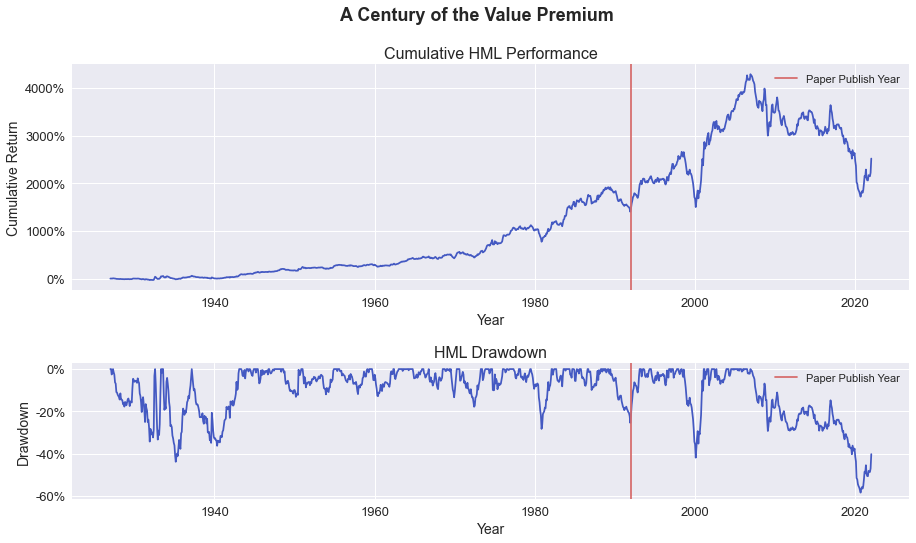

In [5]:
df["HML Cumulative"] = (1+df["HML"]).cumprod()
df["HML Drawdown"] = df["HML Cumulative"] / df["HML Cumulative"].cummax() - 1

figure, axes = plt.subplots(2, gridspec_kw={'height_ratios': [5, 3]}, figsize=(15,8))
plt.subplots_adjust(hspace=0.4)
figure.suptitle("A Century of the Value Premium", fontsize=18, fontweight="bold")

axes[0].plot(df["HML Cumulative"]-1, color="#4459c2")
axes[0].axvline(x=(1992-1970)*365, label="Paper Publish Year", color="#d66b6b")

axes[0].set_title("Cumulative HML Performance", size=16)
axes[0].set_xlabel("Year", size=14)
axes[0].set_ylabel("Cumulative Return", size=14)
axes[0].tick_params(axis="x", labelsize=13)

yticks = np.linspace(0, (df["HML Cumulative"]-1).max() // 10 * 10, 5)
axes[0].set_yticks(yticks)
axes[0].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)

axes[0].legend(fontsize=11, loc="upper right");

axes[1].plot(df["HML Drawdown"], color="#4459c2")
axes[1].axvline(x=(1992-1970)*365, label="Paper Publish Year", color="#d66b6b")

axes[1].set_title("HML Drawdown", size=16)
axes[1].set_xlabel("Year", size=14)
axes[1].set_ylabel("Drawdown", size=14)
axes[1].tick_params(axis="x", labelsize=13)

yticks = [-0.6,-0.4,-0.2, 0]
axes[1].set_yticks(yticks)
axes[1].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)

axes[1].legend(fontsize=11, loc="upper right");

... and the failure of the value premium was both present in large and small caps, although higher in magnitude in the large cap segment.

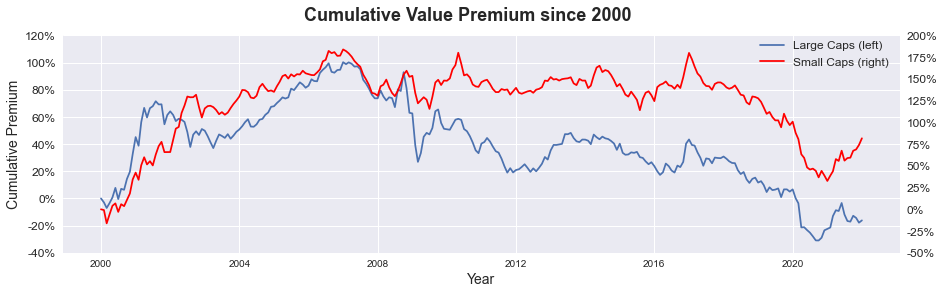

In [6]:
df["Large High B/M"] = bm_size_sorted_data["Average Value Weighted Returns Monthly"]["BIG HiBM"] / 100
df["Large Low B/M"] = bm_size_sorted_data["Average Value Weighted Returns Monthly"]["BIG LoBM"] / 100
df["Small High B/M"] = bm_size_sorted_data["Average Value Weighted Returns Monthly"]["SMALL HiBM"] / 100
df["Small Low B/M"] = bm_size_sorted_data["Average Value Weighted Returns Monthly"]["SMALL LoBM"] / 100

df["Large Value Premium"] = df["Large High B/M"] - df["Large Low B/M"] 
df["Small Value Premium"] = df["Small High B/M"] - df["Small Low B/M"]

fig, ax1 = plt.subplots(figsize=(15,4))
ax2 = ax1.twinx()
ax2.grid(False)
fig.suptitle("Cumulative Value Premium since 2000", fontsize=18, fontweight="bold")

ax1.plot((1+df.loc["2000-01-01":, "Large Value Premium"].shift(1).fillna(0)).cumprod()-1, label="Large Caps (left)")
ax2.plot((1+df.loc["2000-01-01":, "Small Value Premium"].shift(1).fillna(0)).cumprod()-1, label="Small Caps (right)", color="red")

ax1.set_xlabel("Year", fontsize=14)
ax1.set_ylabel("Cumulative Premium", fontsize=14)

yticks1 = ax1.get_yticks().tolist()
ax1.set_yticks(yticks1)
ax1.set_yticklabels([f"{ret:.0%}" for ret in yticks1], fontsize=12)
yticks2 = ax2.get_yticks().tolist()
ax2.set_yticks(yticks2)
ax2.set_yticklabels([f"{ret:.0%}" for ret in yticks2], fontsize=12)

fig.legend(fontsize=12, bbox_to_anchor=(0,0,0.9,0.9));

While some argue that book values are a flawed measure of valuations as highly profitable technology companies with low book-values become more relevant today, the results look similar if we take net-earnings or cashflows instead of book-values.

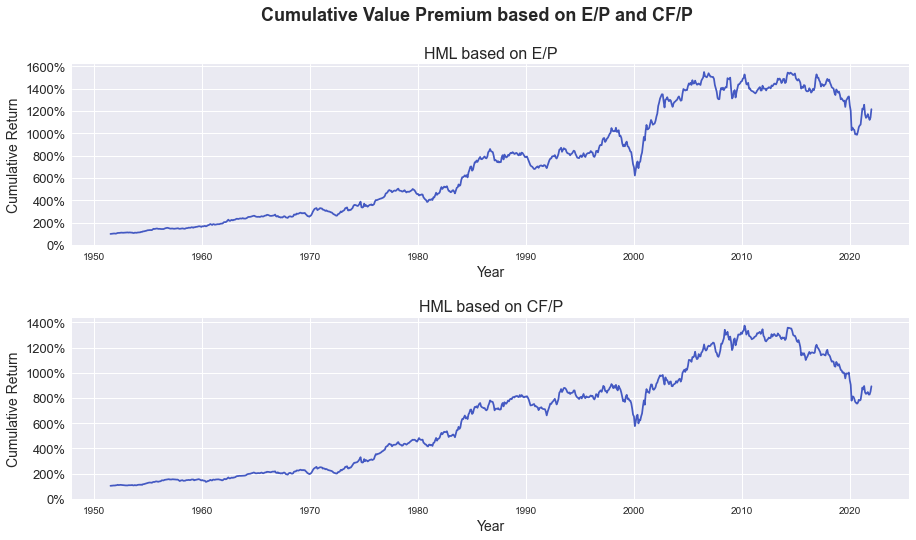

In [7]:
df["HML E/P"] = (
    ep_size_sorted_data["Value Weight Average Returns Monthly"]["BIG HiEP"]
    + ep_size_sorted_data["Value Weight Average Returns Monthly"]["SMALL HiEP"]
    - ep_size_sorted_data["Value Weight Average Returns Monthly"]["BIG LoEP"]
    - ep_size_sorted_data["Value Weight Average Returns Monthly"]["SMALL LoEP"]
) / 2 / 100
df["HML E/P Cumulative"] = (1+df["HML E/P"]).cumprod()

df["HML CF/P"] = (
    cfp_size_sorted_data["Value Weight Average Returns Monthly"]["BIG HiCFP"]
    + cfp_size_sorted_data["Value Weight Average Returns Monthly"]["SMALL HiCFP"]
    - cfp_size_sorted_data["Value Weight Average Returns Monthly"]["BIG LoCFP"]
    - cfp_size_sorted_data["Value Weight Average Returns Monthly"]["SMALL LoCFP"]
) / 2 / 100
df["HML CF/P Cumulative"] = (1+df["HML CF/P"]).cumprod()

figure, axes = plt.subplots(2, figsize=(15,8))
plt.subplots_adjust(hspace=0.4)
figure.suptitle("Cumulative Value Premium based on E/P and CF/P", fontsize=18, fontweight="bold")

axes[0].plot(df["HML E/P Cumulative"], color="#4459c2")
axes[0].set_title("HML based on E/P", size=16)
axes[0].set_xlabel("Year", size=14)
axes[0].set_ylabel("Cumulative Return", size=14)
yticks = np.linspace(0, (df["HML E/P Cumulative"]-1).max() // 2 * 2 + 2, 9)
axes[0].set_yticks(yticks)
axes[0].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13);

axes[1].plot(df["HML CF/P Cumulative"], color="#4459c2")
axes[1].set_title("HML based on CF/P", size=16)
axes[1].set_xlabel("Year", size=14)
axes[1].set_ylabel("Cumulative Return", size=14)
yticks = np.linspace(0, (df["HML CF/P Cumulative"]-1).max() // 2 * 2 + 2, 8)
axes[1].set_yticks(yticks)
axes[1].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13);

Looking at the correlations between alternative measures of the value premium, it also becomes clear that it does not matter which fundamental variable we use.

In [8]:
np.round(df[["HML", "HML E/P", "HML CF/P"]].corr(), 2)

,HML,HML E/P,HML CF/P
HML,1.00,0.85,0.83
HML E/P,0.85,1.00,0.89
HML CF/P,0.83,0.89,1.00


In [9]:
print("Since 1992,...")
for factor in ("Mkt-RF", "SMB", "HML"):   
    ols_fit = OLS(df.loc["1992-01-01":, factor], [1 for _ in range(len(df.loc["1992-01-01":, :].index))]).fit()
    mean = ols_fit.params["const"]
    tstat = ols_fit.tvalues["const"]
    print(f"...the {factor} factor returned an average of {mean:.2%} per month with a t-statistic of {tstat:.2f}.")
print("")
print("Since 2015,...")
for factor in ("RMW", "CMA"):   
    ols_fit = OLS(df.loc["2015-01-01":, factor], [1 for _ in range(len(df.loc["2015-01-01":, :].index))]).fit()
    mean = ols_fit.params["const"]
    tstat = ols_fit.tvalues["const"]
    print(f"...the {factor} factor returned an average of {mean:.2%} per month with a t-statistic of {tstat:.2f}.")

Since 1992,...
...the Mkt-RF factor returned an average of 0.74% per month with a t-statistic of 3.27.
...the SMB factor returned an average of 0.12% per month with a t-statistic of 0.70.
...the HML factor returned an average of 0.21% per month with a t-statistic of 1.20.

Since 2015,...
...the RMW factor returned an average of 0.37% per month with a t-statistic of 1.70.
...the CMA factor returned an average of -0.06% per month with a t-statistic of -0.26.


With all four factors failing out-of-sample, the question arises whether the factors can deliver any premium going forward.
Aside from the nature of the model itself, there are 3 arguments that, considered individually or together, can invalidate the claim that the recent data points to an arbitraged away value premium:
<br>
1. It is simply the result of chance.
2. The underperformance is explained by changing valuations
3. Macroeconomic shifts affected value and growth stocks differently

**1. The underperformance is the result of chance**
<br>
Given that all factors carry a sizable amount of risk in the form of volatility, it should be of no surprise that a factor with positive mean can underperform for a lengthy period. For example, for an iid normally distributed white noise process with a yearly mean return of 10% and 20% yearly volatility, there is still a probability of >2% that the process realizes a mean return <0 over a period of 20 years. Likewise, the US market portfolio showed multiple periods of 20 year underperformance against bonds.
<br>
So let's analyze the probability that the HML underperformance is due to chance:

In [10]:
prior_mean = df.loc[:"1992-01-01", "HML"].mean()
prior_std = df.loc[:"1992-01-01", "HML"].std()

Pior to publication in 1992, the Value Premium had delivered an average monthly excess return of

In [11]:
print(f"{prior_mean:.2%}")

0.42%


with a monthly volatility of

In [12]:
print(f"{prior_std:.2%}.")

3.68%.


Assuming a gaussian distribution and the same mean and volatility pre- and post-publication, we can compute the probability that the value premium returns an average below the realized average post-publication. Given the increasing number of factor ETFs to give retail investors access to alternative factor premia, and investors needing some time to fully adapt to new academic research, I do the same for the subsamples of 1997, 2002, 2007 onwards.

In [13]:
print("The respective sample size of each considered subsample is as follows:\n")
for year in (1992, 1997, 2002, 2007):
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    print(f"The sample size spanning from January {year} to today is {sample_size} months.")

The respective sample size of each considered subsample is as follows:

The sample size spanning from January 1992 to today is 361 months.
The sample size spanning from January 1997 to today is 301 months.
The sample size spanning from January 2002 to today is 241 months.
The sample size spanning from January 2007 to today is 181 months.


Turning to the probabilities, we get the following values.

In [14]:
for year in (1992, 1997, 2002, 2007):
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    std_err = df.loc[f"{year}-01-01":, "HML"].std() / np.sqrt(sample_size)
    realized_mean = df.loc[f"{year}-01-01":, "HML"].mean()
    mean_diff = realized_mean - prior_mean
    z_value = mean_diff / std_err
    p_value = norm.cdf(z_value)
    print(f"For the subsample from January {year} to today, the probability of an average return less than {realized_mean:.2%} per month is {p_value:.2%}")

For the subsample from January 1992 to today, the probability of an average return less than 0.21% per month is 10.96%
For the subsample from January 1997 to today, the probability of an average return less than 0.10% per month is 5.04%
For the subsample from January 2002 to today, the probability of an average return less than -0.01% per month is 1.12%
For the subsample from January 2007 to today, the probability of an average return less than -0.23% per month is 0.33%


So far, one could certainly (and possibly unsurpringly) argue that the value premium has a structural break between pre- and post-publication of the paper.
However, running the same for a hypothesis of mean 0 post-publication gives the following results:

In [15]:
for year in (1992, 1997, 2002, 2007):
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    std_err = df.loc[f"{year}-01-01":, "HML"].std() / np.sqrt(sample_size)
    realized_mean = df.loc[f"{year}-01-01":, "HML"].mean()
    mean_diff = realized_mean - 0
    z_value = mean_diff / std_err
    p_value = norm.cdf(z_value)
    print(f"For the subsample from January {year} to today, the probability of an average return less than {realized_mean:.2%} per month is {p_value:.2%}")

For the subsample from January 1992 to today, the probability of an average return less than 0.21% per month is 88.54%
For the subsample from January 1997 to today, the probability of an average return less than 0.10% per month is 68.91%
For the subsample from January 2002 to today, the probability of an average return less than -0.01% per month is 47.08%
For the subsample from January 2007 to today, the probability of an average return less than -0.23% per month is 16.50%


Therefore, based on the assumptions and the mere data, it is not possible to argue that the value premium is dead.
<br>
The biggest issue though is that the empirical distribution of the value premium is indeed non-normal, although I assumed normality until now.

In [16]:
prior_skew = df.loc[:"1992-01-01", "HML"].skew()
prior_kurt = df.loc[:"1992-01-01", "HML"].kurt()
jb = jarque_bera(df.loc[:"1992-01-01", "HML"]).pvalue

Its skewness is

In [17]:
np.round(prior_skew, 2)

2.73

and its excess kurtosis is

In [18]:
np.round(prior_kurt, 2)

22.91

, both well above that of a normal distribution. Accordingly, a jarque-bera test easily rejects the hypothesis of a normal distribution with a significance level <1%

In [19]:
print(f"{jb:.2%}")

0.00%


The empirical distribution compared to a normal distribution with same mean and variance also shows the extreme kurtosis:

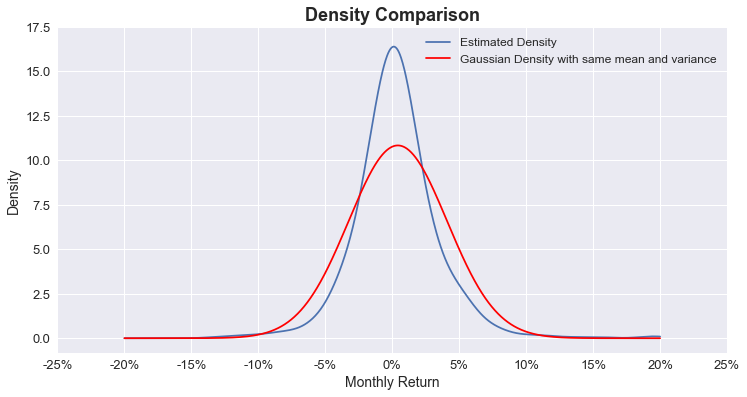

In [20]:
estimated_density = gaussian_kde(df.loc[:"1992-01-01", "HML"])

x = np.linspace(-0.2, 0.2, 1000)
plt.plot(x, estimated_density(x), label="Estimated Density")
plt.plot(x, norm.pdf(x, prior_mean, prior_std), label="Gaussian Density with same mean and variance", color="red")

plt.title("Density Comparison", fontsize=18, fontweight="bold")
plt.ylabel("Density", fontsize=14)
plt.xlabel("Monthly Return", fontsize=14)

xticks = plt.xticks()[0]
plt.xticks(xticks, [f"{ret:.0%}" for ret in xticks], fontsize=13)
yticks = plt.yticks()[0]
plt.yticks(yticks[1:], yticks[1:], fontsize=13)

plt.legend(fontsize=12);

Therefore, it is important to account for the non-normality and compute the same probabilities before by incorporating the empirical distribution instead of assuming normality. For that, I bootstrap intervals by drawing n times (n=sample size) with replacement from the empirical distribution until January 1992. I do it 100.000 times for each subsample and check the probability of an average return less than the respective realized return.

In [21]:
series = {}
sample_size = df.loc["1992-01-01":, "HML"].count()
for i in range(100_000):
    series[i] = pd.Series(np.random.choice(df.loc[:f"1992-01-01", "HML"], sample_size))
bootstrapped_df = pd.DataFrame(series)
bootstrapped_df

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,0.0044,0.0057,-0.0141,-0.0163,0.0170,0.0552,0.0407,-0.0018,-0.0113,0.0341,...,-0.0319,0.0590,-0.0316,0.0169,-0.0064,0.0053,0.0085,0.0148,0.0000,0.0032
1,0.0223,-0.0391,0.0217,0.0127,0.0068,-0.0200,0.0013,-0.0014,0.0161,-0.0159,...,-0.0012,-0.0249,0.0383,0.0205,0.0147,-0.0180,-0.0073,-0.0161,0.0130,0.0152
2,0.0032,0.0140,0.0279,-0.0197,0.0338,0.0057,-0.0049,0.0262,0.0464,0.0023,...,0.0323,0.0539,-0.0063,0.0152,0.0061,-0.0121,-0.0062,0.0539,-0.0403,0.0169
3,0.0147,-0.0641,-0.0249,-0.0375,-0.0169,-0.0154,0.0097,0.0523,0.0047,-0.0132,...,0.0399,-0.0550,0.0085,-0.0367,-0.0628,0.0423,-0.0092,-0.0138,0.0000,0.0079
4,0.0087,0.0043,0.0130,0.1173,0.0453,0.0650,0.0020,0.0206,-0.0243,0.0008,...,0.0582,-0.0011,0.0139,0.0507,-0.0043,-0.0061,-0.0231,-0.0065,-0.0065,-0.0039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,-0.0594,-0.0114,-0.0401,-0.0020,-0.0142,0.0327,-0.0751,-0.0367,-0.0169,0.0135,...,0.0600,0.0281,-0.0285,0.0099,0.0081,-0.0012,-0.0058,-0.0152,0.0137,0.0068
357,-0.0183,0.0085,0.0214,0.0067,-0.0256,0.0388,0.0054,0.0341,-0.0161,0.0252,...,0.0262,-0.0134,-0.0550,0.0014,0.0085,-0.0169,0.0576,0.0250,0.0090,0.1010
358,0.0081,-0.1098,0.0038,0.0274,0.0049,0.0327,-0.0837,0.0217,0.0464,0.0252,...,0.0023,-0.0132,0.0605,-0.0367,-0.0427,-0.0533,0.0132,0.0282,0.0012,-0.0159
359,0.0333,0.3561,0.0002,0.0028,-0.0003,-0.0048,-0.0110,-0.0231,0.0736,-0.0418,...,-0.0071,-0.0421,-0.0094,-0.0011,-0.0012,0.0170,0.0093,0.0104,-0.0197,-0.0266


Let's compute the probability of getting a mean return of less than the realized mean return for each subsample by counting the ocurrences and diving it by the total number of bootstrap samples.

In [22]:
for year in (1992, 1997, 2002, 2007):
    realized_mean = df.loc[f"{year}-01-01":, "HML"].mean()
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    prob = (bootstrapped_df.iloc[:sample_size, :].mean().sort_values().reset_index(drop=True) < realized_mean).sum() / 100_000
    print(f"For the subsample from January {year} to today, the probability of an average return less than {realized_mean:.2%} per month is {prob:.2%}")

For the subsample from January 1992 to today, the probability of an average return less than 0.21% per month is 13.66%
For the subsample from January 1997 to today, the probability of an average return less than 0.10% per month is 6.08%
For the subsample from January 2002 to today, the probability of an average return less than -0.01% per month is 2.87%
For the subsample from January 2007 to today, the probability of an average return less than -0.23% per month is 0.52%


And the same results in graphical representation look as follows:

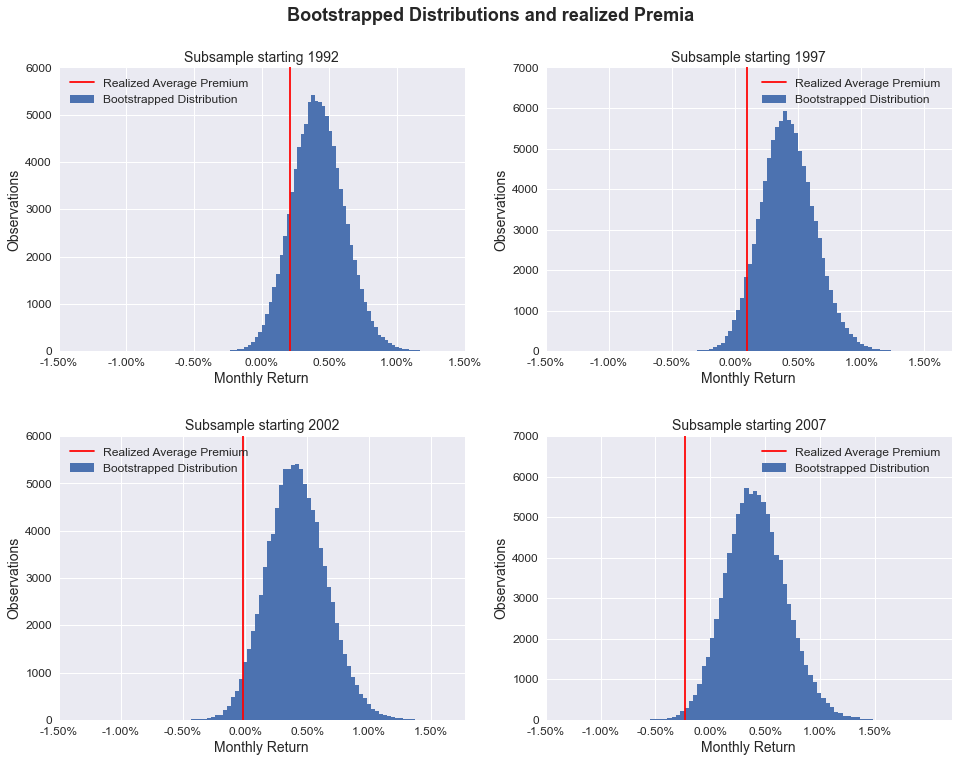

In [23]:
figure, axes = plt.subplots(2, 2, figsize=(16,12))
plt.subplots_adjust(hspace=0.3)
figure.suptitle("Bootstrapped Distributions and realized Premia", fontsize=18, fontweight="bold", y=0.95)

for year, (x, y) in zip((1992, 1997, 2002, 2007), ((0,0), (0,1), (1,0), (1,1))):
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    axes[x,y].hist(bootstrapped_df.iloc[:sample_size, :].mean(), bins=70, label="Bootstrapped Distribution")
    axes[x,y].axvline(df.loc[f"{year}-01-01":, "HML"].mean(), color="red", label="Realized Average Premium")
    
    axes[x,y].set_title(f"Subsample starting {year}", fontsize=14)
    axes[x,y].set_xlabel("Monthly Return", fontsize=14)
    axes[x,y].set_ylabel("Observations", fontsize=14)
    
    xticks = np.linspace(-0.015, 0.015, 7)
    axes[x,y].set_xticks(xticks)
    axes[x,y].set_xticklabels([f"{ret:.2%}" for ret in xticks], fontsize=12)
    yticks = axes[x,y].get_yticks().tolist()
    axes[x,y].set_yticks(yticks)
    axes[x,y].set_yticklabels([int(obs) for obs in yticks], fontsize=12)
    
    axes[x,y].legend(fontsize=12)

Although the probabilities are a bit higher than when I assumed normality, the main message remains and the post-publication value premium is either an outlier or the process exhibited a structural break. However, as I have shown, the hypothesis that the post-publication mean return is zero cannot be rejected (which can also be seen if we shift the boostrapped distributions to the left). Therefore, looking at the mere data, there is no indication of a dead value premium.

**2. The underperformance is explained by valuations**
<br>

While a basket of stocks with the same characteristics (e.g. same magnitude of market beta) should deliver its expected premium over the long term, it can deviate quite a lot from that over the shorter term for various reasons. Valuations of stocks change continuously as the business cycle affects the overall risk aversion, new news getting priced in and many other factors.
<br>
The shorter the period, the higher is the effect of changing valuations compared to the embedded premium on returns.
For example, the daily equity premium is a few basis points and the volatility overweighs, but over decades, positive and negative shocks cancel each other out and the premium overweighs. Likewise, following the financial crisis 2008/09, the realized US equity premium was well above its historical average since it benefited quite a lot from changes in valuations.

The US equity premium from 1927 to today was

In [24]:
equity_premium = df['Mkt-RF'].mean()*12
print(f"{equity_premium:.2%}")

8.21%


, while the average from 2009 to today was

In [25]:
equity_premium_recent = df.loc["2009-01-01": , "Mkt-RF"].mean()*12
print(f"{equity_premium_recent:.2%}")

15.19%


or

In [26]:
sigma = ((df['Mkt-RF'].std() * np.sqrt(12)) / np.sqrt(df.loc['2009-01-01': , 'Mkt-RF'].count()/12))
np.round((equity_premium_recent - equity_premium) / sigma, 2)

1.36

standard deviations above its expected value using the full sample mean and assuming normality. *(which, again, is not a proper assumption, but the actual results would not change that much, but would bloat up the notebook)*

Accordingly, a large portion of US stock returns since 2009 have been the result of changing valuations, measured in terms of the [CAPE](https://www.nber.org/system/files/working_papers/w8221/w8221.pdf), and not by fundamental drivers such as abnormally high earnings growth or dividends.

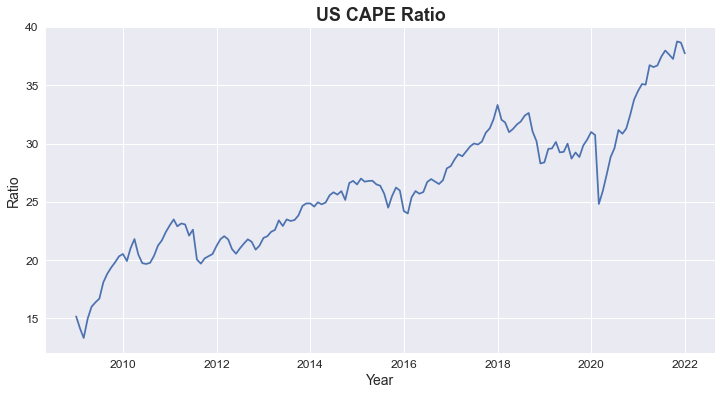

In [27]:
plt.plot(df.loc["2009-01-01":, "CAPE"])

plt.title("US CAPE Ratio", fontsize=18, fontweight="bold")
plt.ylabel("Ratio", fontsize=14)
plt.xlabel("Year", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In a similar manner, the realized value premium is the result of three factors:
1. The difference of the embedded risk premia between low-valued and high-valued stocks
2. The change in the relative valuations
3. Unexpected fundamental changes that do not affect the relative valuations
<br>

Again, over a long enough sample, (2) and (3) should have little effect, but over the short term, they can be the main driver of the value premium.

If we take a look at the relative valuations of stocks with high book-to-market ratios and those with low book-to-market ratios, both in in the small and large caps, we can see that relative valuations increased dramatically since the start of the HML drawdown in January 2007.

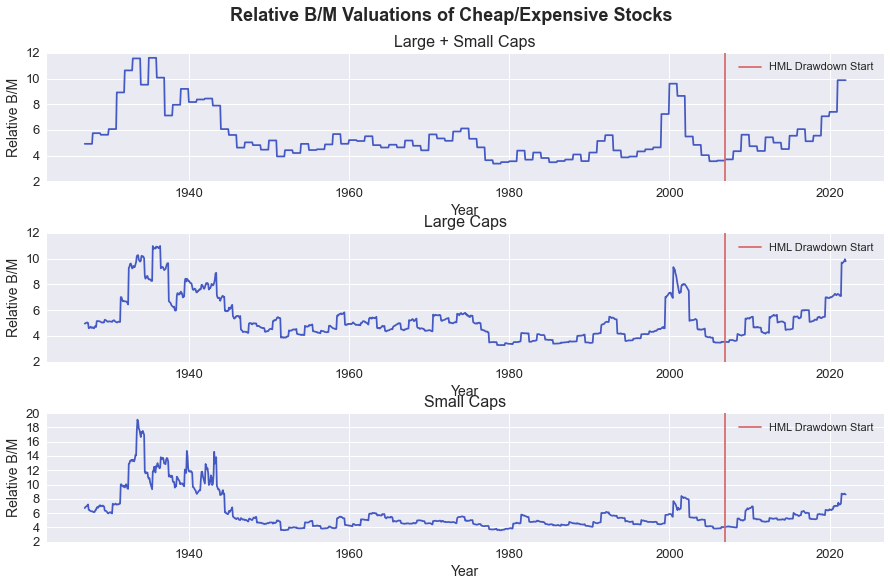

In [28]:
df["High B/M Ratio"] = bm_sorted_data["Value Weight Average of BE / ME"]["Hi 30"]
df["Low B/M Ratio"] = bm_sorted_data["Value Weight Average of BE / ME"]["Lo 30"]
df["Large High B/M Ratio"] = bm_size_sorted_data["Value Weight Average of BE/ME"]["BIG HiBM"]
df["Large Low B/M Ratio"] = bm_size_sorted_data["Value Weight Average of BE/ME"]["BIG LoBM"]
df["Small High B/M Ratio"] = bm_size_sorted_data["Value Weight Average of BE/ME"]["SMALL HiBM"]
df["Small Low B/M Ratio"] = bm_size_sorted_data["Value Weight Average of BE/ME"]["SMALL LoBM"]

df["Valuation Spread All Stocks"] = (df["High B/M Ratio"] / df["Low B/M Ratio"]).ffill()
df["Valuation Spread Large Stocks"] = df["Large High B/M Ratio"] / df["Large Low B/M Ratio"]
df["Valuation Spread Small Stocks"] = df["Small High B/M Ratio"] / df["Small Low B/M Ratio"]

figure, axes = plt.subplots(3, figsize=(15,9))
plt.subplots_adjust(hspace=0.4)
figure.suptitle("Relative B/M Valuations of Cheap/Expensive Stocks", fontsize=18, fontweight="bold", y=0.95)

axes[0].plot(df["Valuation Spread All Stocks"], color="#4459c2")
axes[0].axvline(x=(2007-1970)*365, label="HML Drawdown Start", color="#d66b6b")

axes[0].set_title("Large + Small Caps", size=16)
axes[0].set_xlabel("Year", size=14)
axes[0].set_ylabel("Relative B/M", size=14)
axes[0].tick_params(axis="x", labelsize=13)

yticks = np.linspace(2, df["Valuation Spread All Stocks"].max() // 2 * 2 + 2, int(df["Valuation Spread All Stocks"].max() // 2)+1)
axes[0].set_yticks(yticks)
axes[0].set_yticklabels([int(tick) for tick in yticks], size=13)

axes[0].legend(fontsize=11, loc="upper right");

axes[1].plot(df["Valuation Spread Large Stocks"], color="#4459c2")
axes[1].axvline(x=(2007-1970)*365, label="HML Drawdown Start", color="#d66b6b")

axes[1].set_title("Large Caps", size=16)
axes[1].set_xlabel("Year", size=14)
axes[1].set_ylabel("Relative B/M", size=14)
axes[1].tick_params(axis="x", labelsize=13)

yticks = np.linspace(2, df["Valuation Spread Large Stocks"].max() // 2 * 2 + 2, int(df["Valuation Spread Large Stocks"].max() // 2)+1)
axes[1].set_yticks(yticks)
axes[1].set_yticklabels([int(tick) for tick in yticks], size=13)

axes[1].legend(fontsize=11, loc="upper right");

axes[2].plot(df["Valuation Spread Small Stocks"], color="#4459c2")
axes[2].axvline(x=(2007-1970)*365, label="HML Drawdown Start", color="#d66b6b")

axes[2].set_title("Small Caps", size=16)
axes[2].set_xlabel("Year", size=14)
axes[2].set_ylabel("Relative B/M", size=14)
axes[2].tick_params(axis="x", labelsize=13)

yticks = np.linspace(2, df["Valuation Spread Small Stocks"].max() // 2 * 2 + 2, int(df["Valuation Spread Small Stocks"].max() // 2)+1)
axes[2].set_yticks(yticks)
axes[2].set_yticklabels([int(tick) for tick in yticks], size=13)

axes[2].legend(fontsize=11, loc="upper right");

While it can be argued that technology companies become more important and are generally more profitable than other sectors, which dampens their book-to-market ratios c.p., the picture looks similar if we look at the spread of earnings-to-price or cashflow-to-price ratios.

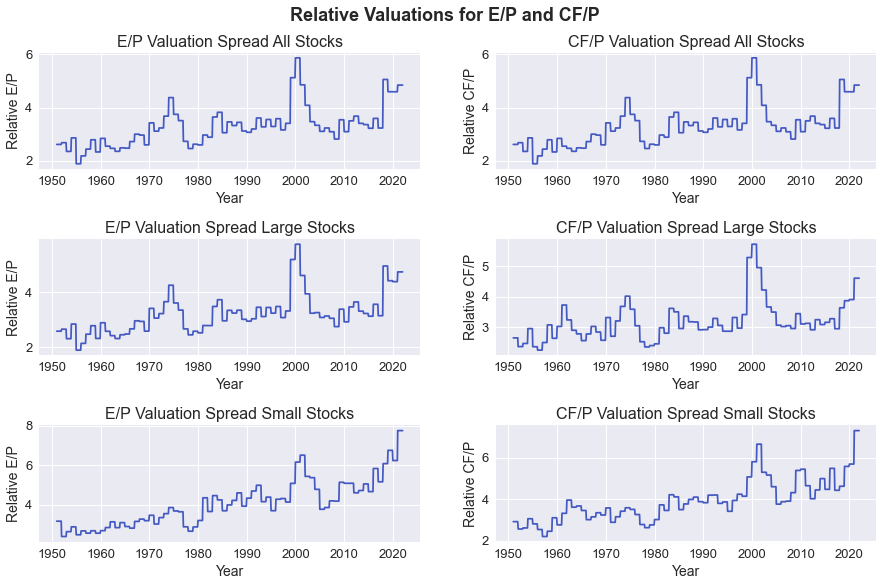

In [29]:
df["High E/P Ratio"] = ep_sorted_data["Value Weight Average of E / ME"]["Hi 30"]
df["Low E/P Ratio"] = ep_sorted_data["Value Weight Average of E / ME"]["Lo 30"]
df["E/P Valuation Spread All Stocks"] = (df["High E/P Ratio"] / df["Low E/P Ratio"]).ffill()

df["Large High E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["BIG HiEP"]
df["Large Low E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["BIG LoEP"]
df["E/P Valuation Spread Large Stocks"] = (df["Large High E/P Ratio"] / df["Large Low E/P Ratio"]).ffill()

df["Small High E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["SMALL HiEP"]
df["Small Low E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["SMALL LoEP"]
df["E/P Valuation Spread Small Stocks"] = (df["Small High E/P Ratio"] / df["Small Low E/P Ratio"]).ffill()

df["High CF/P Ratio"] = cfp_sorted_data["Value Weight Average of CF / ME"]["Hi 30"]
df["Low CF/P Ratio"] = cfp_sorted_data["Value Weight Average of CF / ME"]["Lo 30"]
df["CF/P Valuation Spread All Stocks"] = (df["High E/P Ratio"] / df["Low E/P Ratio"]).ffill()

df["Large High CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["BIG HiCFP"]
df["Large Low CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["BIG LoCFP"]
df["CF/P Valuation Spread Large Stocks"] = (df["Large High CF/P Ratio"] / df["Large Low CF/P Ratio"]).ffill()

df["Small High CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["SMALL HiCFP"]
df["Small Low CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["SMALL LoCFP"]
df["CF/P Valuation Spread Small Stocks"] = (df["Small High CF/P Ratio"] / df["Small Low CF/P Ratio"]).ffill()


figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,9))
plt.subplots_adjust(hspace=0.6)
figure.suptitle("Relative Valuations for E/P and CF/P", fontsize=18, fontweight="bold", y=0.95)

for row, dataset in enumerate((
    "E/P Valuation Spread All Stocks",
    "E/P Valuation Spread Large Stocks",
    "E/P Valuation Spread Small Stocks"
)):

    axes[row, 0].plot(df[dataset], color="#4459c2")
    axes[row, 0].set_title(dataset, size=16)
    axes[row, 0].set_xlabel("Year", size=14)
    axes[row, 0].set_ylabel(f"Relative {dataset.split()[0]}", size=14)
    axes[row, 0].tick_params(axis="both", labelsize=13)

for row, dataset in enumerate((
    "CF/P Valuation Spread All Stocks",
    "CF/P Valuation Spread Large Stocks",
    "CF/P Valuation Spread Small Stocks"
)):
    axes[row, 1].plot(df[dataset], color="#4459c2")
    axes[row, 1].set_title(dataset, size=16)
    axes[row, 1].set_xlabel("Year", size=14)
    axes[row, 1].set_ylabel(f"Relative {dataset.split()[0]}", size=14)
    axes[row, 1].tick_params(axis="both", labelsize=13)

**3. Macroeconomic shifts affected value and growth stocks differently**
<br>